# Helper notebook
## Programming Exercises 7.3: kernel SVM
*The goal is to implement and evaluate different kernels for SVMs for one dataset.*


*We start by importing the necessary libraries.*

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

from sklearn import datasets

*Then we generate our random dataset; this will be 2D data that is not linearly separable. In fact, the data will follow concentric rings.*

In [6]:
N = 200 # number of samples
c = 0.5 # scale factor between inner and outer circles
noise = 0.1 # noise parameter

# generate data
x_vals, r_vals = datasets.make_circles(n_samples=N, factor=c, noise=noise)
# if a value in y_vals is 1, we leave it at one, but if it is 0, we set it to -1
r_vals = np.where(r_vals, 1, -1)

class1_idxs = np.flatnonzero(r_vals == 1)
class1_x = x_vals[class1_idxs]
class1_r = r_vals[class1_idxs]
class2_idxs = np.flatnonzero(r_vals == -1)
class2_x = x_vals[class2_idxs]
class2_r = r_vals[class2_idxs]

*We can take a quick look at our data to get a sense of what we're trying to predict.*

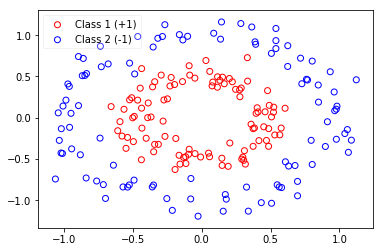

In [7]:
plt.scatter(class1_x[:, 0], class1_x[:, 1],
            label = "Class 1 (+1)",
            color = "none",
            edgecolor = "red"
           )
plt.scatter(class2_x[:, 0], class2_x[:, 1],
            label = "Class 2 (-1)",
            color = "none",
            edgecolor = "blue"
           )
plt.legend(loc="upper left", framealpha=0.25)
plt.show()

*We start a computational graph session.*

In [8]:
sess = tf.Session()

*We declare the batch size (large for SVMs - in this case we set it equal to the number of samples), create the placeholders, and declare the $\pmb{\alpha}$-variable for the SVM model.*

In [9]:
batch_size = N

# initialize placeholders
x = tf.placeholder(shape=[None, 2], dtype=tf.float32)
r = tf.placeholder(shape=[None, 1], dtype=tf.float32)
pred_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# create variables for svm
alpha = tf.Variable(tf.random_normal(shape=[1, batch_size]))

Instructions for updating:
Colocations handled automatically by placer.


### (a)
*Implement:*
* *a linear kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = \mathbf{x}_1^\intercal \mathbf{x}_2$
* *a Gaussian or radial basis function (RBF) kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = e^{(-\gamma \|\mathbf{x}_1 - \mathbf{x}_2 \|^2)}$
* *a polynomial kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = (\mathbf{x}_1^\intercal \mathbf{x}_2 + c)^d$

### Solution (where you have to write code)

Here we will apply the kernel.

In [157]:
#lin_kernel = lambda x, y: np.dot(np.transpose(x), y)
#gaussian_kernel = lambda x, y, a: np.exp(-a * np.linalg.norm(np.subtract(x, y))**2)
#poly_kernel = lambda x, y, d: (np.dot(np.transpose(x), y) + 1)**d

# Linear Kernel
#kernel = tf.matmul(x, tf.transpose(x))

# Gaussian (RBF) kernel
gamma = tf.constant(-50.0)
dist = tf.reduce_sum(tf.square(x), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x,tf.transpose(x)))), tf.transpose(dist))
kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

kernel = tf.matmul(x, tf.transpose(x))

d = 2
c = 1
kernel = tf.pow((tf.matmul(x, tf.transpose(x)) + c), d)

Just like we created the kernel for the training points, we need to create the kernel for the test/prediction points.

Again, comment/uncomment the appropriate lines for using the linear, RBF, or polynomial kernels.

In [158]:
# prediction kernels

# Linear prediction kernel
# pred_kernel = tf.matmul(x, tf.transpose(pred_grid))

# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(pred_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x, tf.transpose(pred_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

pred_kernel = tf.matmul(x, tf.transpose(pred_grid))

d = 2
c = 10
pred_kernel = tf.pow((tf.matmul(x, tf.transpose(pred_grid)) + c), d)

*Next we set up the SVM model and create our loss function. This is done using equation (13.27)*

$$
L_d = \sum_{t} \alpha^t - \frac{1}{2} \sum_{t} \sum_{s} \alpha^t \alpha^s r^t r^s K(\mathbf{x}^t, \mathbf{x}^s),
$$

*however, for TensorFlow we work with arrays, so by defining the matrix $\mathbf{A} = K(\mathbf{x}^t, \mathbf{x}^s) \pmb{\alpha}^\intercal \pmb{\alpha} \mathbf{r} \mathbf{r}^\intercal$, we can sum all its elements to get the double-sum on the right. We can therefore write $L_d$ as*

$$
L_d = \sum_{t} \alpha^t - \frac{1}{2} \sum_{i,j} A_{i,j}
$$

*instead, where $A_{i,j}$ is the value at the $i$th row and $j$th column.*

*Note that $\mathbf{A}$ is in fact a matrix since $K(\mathbf{x}^t, \mathbf{x}^s)$ gives a scalar, $\pmb{\alpha}^\intercal \pmb{\alpha}$ gives us ($1\times N \cdot N\times 1$) another scalar, and $\mathbf{r} \mathbf{r}^\intercal$ gives us ($N \times 1 \cdot 1 \times N$) an $N \times N$-matrix.*

In [159]:
# compute SVM model

alpha_sum = tf.reduce_sum(alpha)

r_matrix = tf.matmul(r, tf.transpose(r))
alpha_prod = tf.matmul(tf.transpose(alpha), alpha)
double_sum = tf.reduce_sum(tf.multiply(kernel, tf.multiply(alpha_prod, r_matrix)))

loss = tf.negative(tf.subtract(alpha_sum, double_sum))

*In order to use the kernel to classify points, we create a prediction operation.  This prediction operation will be the sign (positive or negative) of the model outputs.  The accuracy can then be computed if we know the actual target labels.*

In [160]:
pred_output = tf.matmul(tf.multiply(tf.transpose(r), alpha), pred_kernel)
pred = tf.sign(pred_output - tf.reduce_mean(pred_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(pred), tf.squeeze(r)), tf.float32))

*We now declare the optimizer and variable initialization operations.*

In [161]:
# declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.0005)
train_step = my_opt.minimize(loss)

# initialize variables
init = tf.global_variables_initializer()
sess.run(init)

*We start the training loop for the SVM.  We will randomly choose a batch of points and run the train step.  Then we calculate the loss and accuracy.*

In [162]:
# training loop
temp_losses = []
batch_accs = []
np.random.seed(0) # set this for your experiments to compare the different kernels
for i in range(10000):
    # generate random indices equal to batch_size 
    batch_idxs = np.random.choice(N, size=batch_size)
    # get the corresponding input and target points
    batch_x = x_vals[batch_idxs]
    batch_r = np.transpose([r_vals[batch_idxs]])
    # train the model with this batch
    sess.run(train_step, feed_dict={x: batch_x, r: batch_r})
    
    # calculate temporary train loss and accuracy
    temp_loss = sess.run(loss, feed_dict={x: batch_x, r: batch_r})
    temp_losses.append(temp_loss)
    batch_acc = sess.run(accuracy, feed_dict={x: batch_x, r: batch_r, pred_grid: batch_x})
    batch_accs.append(batch_acc)
    
    if (i+1)%1000==0:
        print("Step #{}".format(i+1))
        print("Loss = ", temp_loss)

Step #1000
Loss =  49.182625
Step #2000
Loss =  -54.55056
Step #3000
Loss =  -42.365654
Step #4000
Loss =  -32.392933
Step #5000
Loss =  -55.452744
Step #6000
Loss =  -5.120697
Step #7000
Loss =  -39.11089
Step #8000
Loss =  -38.446793
Step #9000
Loss =  -38.500114
Step #10000
Loss =  -34.606712


*To plot a pretty picture of the regions we fit, we create a fine mesh to run through our model and get the predictions.*

In [163]:
# find boundaries for contour plot
abscissa_min, abscissa_max = x_vals[:, 0].min()-1, x_vals[:, 0].max()+1
ordinate_min, ordinate_max = x_vals[:, 1].min()-1, x_vals[:, 1].max()+1

# generate mesh grid of points
xx, yy = np.meshgrid(
    np.linspace(abscissa_min, abscissa_max, 1000),
    np.linspace(ordinate_min, ordinate_max, 1000)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# find predictions for grid of points
[grid_preds] = sess.run(pred, feed_dict={
    x: x_vals,
    r: np.transpose([r_vals]),
    pred_grid: grid_points
})
grid_preds = grid_preds.reshape(xx.shape)

*Then we make the plot of our points and our decision boundary.*

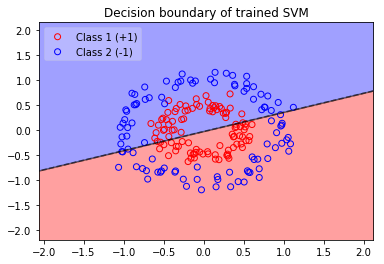

In [164]:
# plot our decision boundary
plt.imshow(
    grid_preds,
    extent=[abscissa_min, abscissa_max, ordinate_min, ordinate_max],
    origin="lower",
    cmap="bwr",
    aspect="auto",
    alpha=0.375
)
plt.contour(xx, yy, grid_preds, 1, colors="black", alpha=0.5)

# plot our points
plt.scatter(class1_x[:, 0], class1_x[:, 1],
    label = "Class 1 (+1)",
    color = "none",
    edgecolor = "red"
)
plt.scatter(class2_x[:, 0], class2_x[:, 1],
    label = "Class 2 (-1)",
    color = "none",
    edgecolor = "blue"
)

# add title and legend
plt.title("Decision boundary of trained SVM")
plt.legend(loc="upper left", framealpha=0.25)
plt.show()

*We can also plot the loss over time and batch accuracy.*

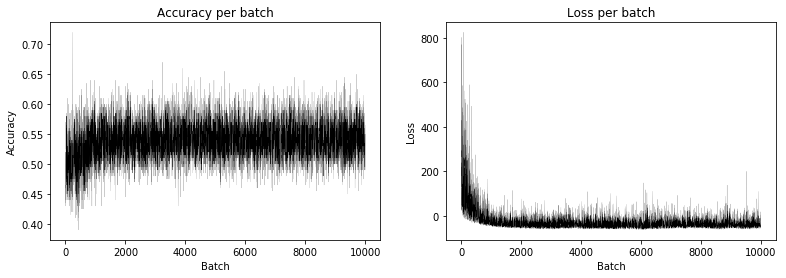

In [165]:
fig = plt.figure(figsize=(13,4))

# plot batch accuracy
ax1 = fig.add_subplot(121)
ax1.plot(batch_accs, color="black", linewidth=0.1)
ax1.set_title("Accuracy per batch")
ax1.set_xlabel("Batch")
ax1.set_ylabel("Accuracy")

# plot loss over time
ax2 = fig.add_subplot(122)
ax2.plot(temp_losses, color="black", linewidth=0.1)
ax2.set_title("Loss per batch")
ax2.set_xlabel("Batch")
ax2.set_ylabel("Loss")

plt.show()

### (b)
*Which of these performs best on the data, in terms of speed and quality? Do not forget to set the random seed to receive reproducible results.*

### (c)
*Test different values of $c$ and $d$ for the polynomial kernel. Which of them work best?*

### (d)
*Test different values of $\gamma$ for the RBF kernel. Which of them works best?*

### (e)
*Change the part of the code which generates the data such that it becomes linearly separable.*

### (f)
*Re-evaluate the three kernels. Do you get the same result?*